In [1]:
import pandas as pd
from scipy.sparse import csr_matrix

data = pd.read_csv('ratings_train.csv')
ratings = csr_matrix(
    (data.rating.values, (data.user_id.values, data.item_id.values)), 
    shape=(len(data.user_id.unique()), 1681)
).toarray()

In [2]:
def predict(self, u, i):
    return self.global_bias+self.user_biases[u]+self.item_biases[i]+self.user_vecs[u]@self.item_vecs[i]

def error(self, u, i):
    pred_rat = self.predict(u, i)
    return self.ratings[u, i] - pred_rat 

In [3]:
def update_biases_and_vectors(self, error, u, i):
    # Update biases
    self.user_biases[u] += self.l_rate*(error - self.alpha*self.user_biases[u])
    self.item_biases[i] += self.l_rate*(error - self.alpha*self.item_biases[i])
    # Update User and item Vectors
    self.user_vecs[u, :] += self.l_rate*(error*self.item_vecs[i, :] - self.alpha*self.user_vecs[u, :])
    self.item_vecs[i, :] += self.l_rate*(error*self.user_vecs[u, :] - self.alpha*self.item_vecs[i, :])

In [4]:
import time, numpy as np
import matplotlib.pyplot as plt

class MatrixFactorization():
    
    def __init__(self, ratings, n_factors=100, l_rate=0.01, alpha=0.01, n_iter=100):
        self.ratings = ratings
        self.n_users, self.n_items = ratings.shape
        self.non_zero_row_ind, self.non_zero_col_ind = ratings.nonzero()
        self.n_interac = len(ratings[np.where(ratings != 0)])
        self.ind_lst = list(range(self.n_interac))
        self.n_factors = n_factors
        self.l_rate = l_rate  # eta0 Constant that multiplies the update term
        self.alpha = alpha  # lambda Constant that multiplies the regularization term
        self.n_iter = n_iter
        self.mse_lst = []
        self.wait = 10
        self.tol = 1e-3
        self.n_iter_no_change = 10
        self.verbose = True
        self.stop = False
        
    def initialize(self, ):
        self.now = time.time()
        # Initialize Bias Values
        self.user_biases = np.zeros(self.n_users)
        self.item_biases = np.zeros(self.n_items)
        # initialize user & item vectors        
        self.user_vecs = np.random.normal(scale=1/self.n_factors, size=(self.n_users, self.n_factors))
        self.item_vecs = np.random.normal(scale=1/self.n_factors, size=(self.n_items, self.n_factors))
        # compute global bias
        self.global_bias = np.mean(self.ratings[np.where(self.ratings != 0)])
        self.evaluate_the_model(0)
        
        
    def predict(self, u, i):
        return self.global_bias+self.user_biases[u]+self.item_biases[i]+self.user_vecs[u]@self.item_vecs[i]
        
    def update_biases_and_vectors(self, error, u, i):
        # Update biases
        self.user_biases[u] += self.l_rate*(error - self.alpha*self.user_biases[u])
        self.item_biases[i] += self.l_rate*(error - self.alpha*self.item_biases[i])
        # Update User and item Vectors
        self.user_vecs[u, :] += self.l_rate*(error*self.item_vecs[i, :] - self.alpha*self.user_vecs[u, :])
        self.item_vecs[i, :] += self.l_rate*(error*self.user_vecs[u, :] - self.alpha*self.item_vecs[i, :])
        
    def evaluate_the_model(self, epoch):
        tot_square_error = 0
        for index in self.ind_lst:
            # Extracting user item information indices in which we have a rating
            u, i = self.non_zero_row_ind[index], self.non_zero_col_ind[index]
            pred_rat = self.predict(u, i)
            tot_square_error += (self.ratings[u, i]-pred_rat)**2
        mse = tot_square_error/self.n_interac
        self.mse_lst.append(mse)
        if self.verbose: 
            print(f"---> Epoch {epoch}")
            temp = np.round(time.time()-self.now, 3)
            print(f"ave mse {np.round(self.mse_lst[-1], 3)} ===> Total training time: {temp} seconds.")
        
    def early_stopping(self, epoch):
        if (self.mse_lst[-2] - self.mse_lst[-1]) <= self.tol:
            if self.wait == self.n_iter_no_change:
                temp = np.round(time.time()-self.now, 3)
                if self.verbose: print(f"Convergence after {epoch} epochs time took: {temp} seconds.")
                self.stop = True
                self.conv_epoch_num = epoch
            self.wait += 1
        else:
            self.wait = 0
        
    def fit(self, ):
        self.initialize()
        for epoch in range(1, self.n_iter):
            np.random.shuffle(self.ind_lst)
            if self.stop == False:
                for index in self.ind_lst:
                    # Extracting user item information indices in which we have a rating
                    u, i = self.non_zero_row_ind[index], self.non_zero_col_ind[index]
                    pred_rat = self.predict(u, i)
                    error = self.ratings[u, i]-pred_rat
                    self.update_biases_and_vectors(error, u, i)
                self.evaluate_the_model(epoch)
                self.early_stopping(epoch)
        self.plot_the_score()
                
    def plot_the_score(self, ):
        plt.figure(figsize=(18,6))
        plt.plot(range(1, 1+len(self.mse_lst)), self.mse_lst, marker='o')
        plt.title("SGD Custom Prepared USER & ITEM vector's Tr MSE loss vs epochs", fontsize=20)
        plt.xlabel('Number of epochs', fontsize=18)
        plt.ylabel('mean square error', fontsize=18)
        plt.xticks(range(1, self.conv_epoch_num+5), fontsize=15, rotation=90)
        plt.yticks(np.linspace(min(self.mse_lst), max(self.mse_lst),15), fontsize=15)
        plt.grid()
        plt.show()

---> Epoch 0
ave mse 1.267 ===> Total training time: 0.957 seconds.
---> Epoch 1
ave mse 0.926 ===> Total training time: 6.959 seconds.
---> Epoch 2
ave mse 0.884 ===> Total training time: 12.91 seconds.
---> Epoch 3
ave mse 0.867 ===> Total training time: 18.746 seconds.
---> Epoch 4
ave mse 0.857 ===> Total training time: 24.636 seconds.
---> Epoch 5
ave mse 0.85 ===> Total training time: 30.516 seconds.
---> Epoch 6
ave mse 0.844 ===> Total training time: 36.331 seconds.
---> Epoch 7
ave mse 0.839 ===> Total training time: 42.712 seconds.
---> Epoch 8
ave mse 0.834 ===> Total training time: 48.529 seconds.
---> Epoch 9
ave mse 0.826 ===> Total training time: 54.368 seconds.
---> Epoch 10
ave mse 0.813 ===> Total training time: 60.152 seconds.
---> Epoch 11
ave mse 0.796 ===> Total training time: 66.382 seconds.
---> Epoch 12
ave mse 0.773 ===> Total training time: 72.205 seconds.
---> Epoch 13
ave mse 0.746 ===> Total training time: 78.024 seconds.
---> Epoch 14
ave mse 0.716 ===> T

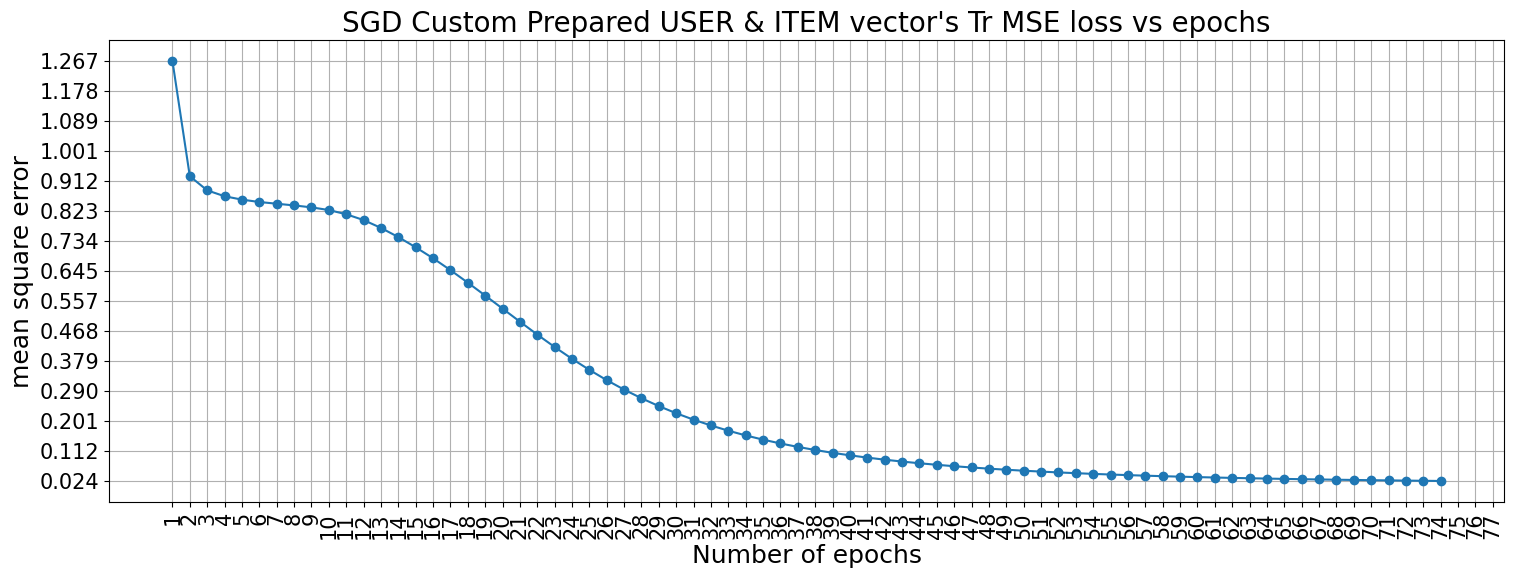

In [5]:
obj = MatrixFactorization(ratings)
obj.fit()